In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import tensorflow as tf
import plot_utils

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
tf.executing_eagerly()

True

In [3]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = cv.resize(dat['listgal'][0,:,:], (64,64))
psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))

gal_up = cv.resize(dat['listgal'][0,:,:], (64*4,64*4))                   # Upsampled to remove alising
psf_up = cv.resize(galsim.Image(img1, copy=True).array, (64*4,64*4))

psf /= np.sum(psf)             # PSF flux = 1
psf_up /= np.sum(psf_up)

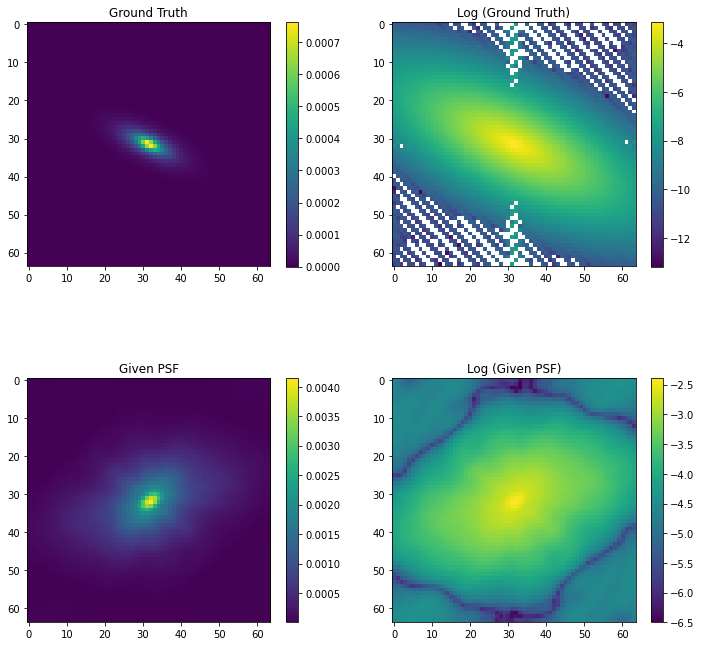

In [6]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal)
plt.colorbar(shrink=0.825)
plt.title('Ground Truth')

plt.subplot(222)
plt.imshow(np.log10(gal))
plt.colorbar(shrink=0.825)
plt.title('Log (Ground Truth)')

plt.subplot(223)
plt.imshow(psf)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

plt.show()

### FFT(Ground Truth) + Gaussian Noise

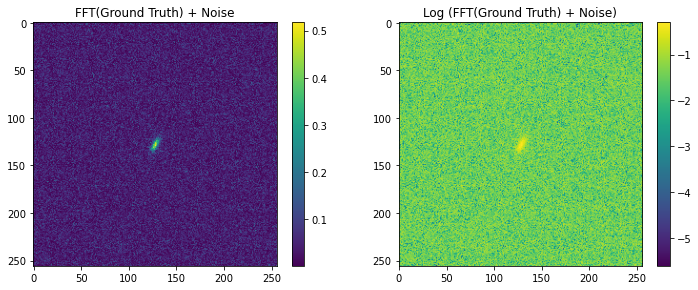

0.05687359927909602


In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal_up))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf_up))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 50                                                          # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

print(sigma_noise)

### Convolve with PSF

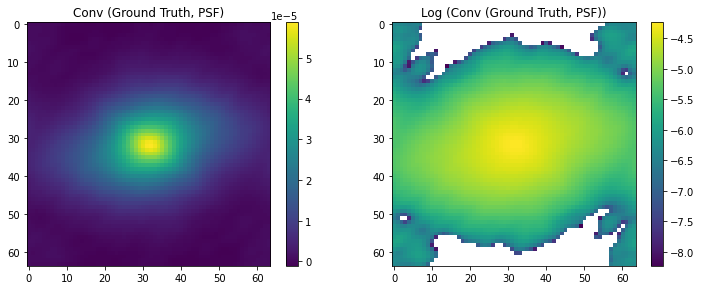

(0.030397305292520816, 0.030397305292520813)

In [8]:
conv = gal_fft_GSO.array * psf_fft

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))     # IFFT to get back to brightness domain
final_gal = cv.resize(final_gal, (64,64))    
final_gal *= (np.sum(gal)/np.sum(final_gal))                                   # Normalisation


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

np.sum(final_gal), np.sum(gal)

# ADMM in TensorFlow

In [9]:
# Convert arrays to tensors

gal_tf = tf.cast(gal, tf.float32)
final_gal_tf = tf.cast(final_gal, tf.float32)
psf_tf = tf.cast(psf, tf.float32)

In [10]:
# Utility Functions

def fftconvolve(image, kernel):
   
    x = tf.signal.fftshift(tf.signal.fft2d(tf.cast(image, tf.complex64)))
    y = tf.signal.fftshift(tf.signal.fft2d(tf.cast(kernel, tf.complex64)))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

    return tf.cast(result, tf.float32)


def fft(data):

    return tf.math.real( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], tf.complex64) * 
                         tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(tf.cast(data, tf.complex64)))) )


def ifft(data):

    return tf.math.real( tf.convert_to_tensor(data.get_shape().as_list()[0], tf.complex64) *
                         tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(tf.cast(data, tf.complex64)))) )


def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)


def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
    return tf.cast(tf.math.reduce_max(normH), tf.float32)

In [11]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )
     
    return tf.keras.backend.eval(cost_val).flatten()


# Compute gradient step size   
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.float32) / 
            ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, n_iter):
 
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.float32)
    z_0 = tf.cast(z_0, tf.float32)
    mu_0 = tf.cast(mu_0, tf.float32)
    rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.float32)      # max rho value
    eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1
  
    # declare variables
    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.float32)
    count = 0
 
    # ADMM parameters
    
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.float32)      

    # FISTA parameters
    
    t_k = tf.cast(1.0, tf.float32)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.float32)
    
    # square of spectral radius of convolution matrix
    
    sv = max_sv(psf, sigma, rho_k)         

    # The gradient descent step
    
    alpha = get_alpha(rho_k, sv, sigma) 

    # ADMM Loop 
    
    for k in range(n_iter):
    
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)             # Project negative values
        
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1
  
        ## Denoising sub-step
     
        z_k1 = x_k1 + (mu_k / rho_k)

        ## mu update
        
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
        
        ## Cost
        
        cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))
          
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_tf.get_shape().as_list()[0], tf.float32) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)
    
        # Update all variables
        
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)      
      
        # Reconstruction
        
        final_im = x_k
                     
        # Compute NMSE
        
        nmse_arr[k] = nmse(gal_tf, final_im)
              
        # Check if optimal reconstruction is achieved
        
        if nmse_arr[k]==np.min(nmse_arr):
            x_opt = final_im     
        
        # Display plots
        
        if (k+1)%disp_step==0 and k!=0:
            plot_utils.plot_iter(final_im, gal, y, k+1)
               
    return x_opt, cost, nmse_arr

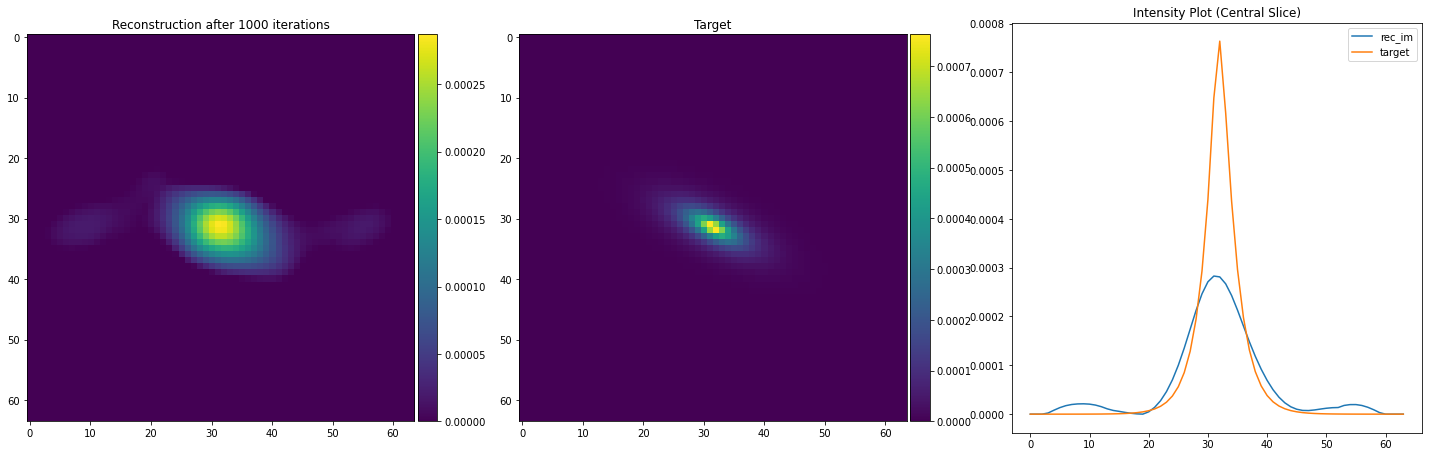

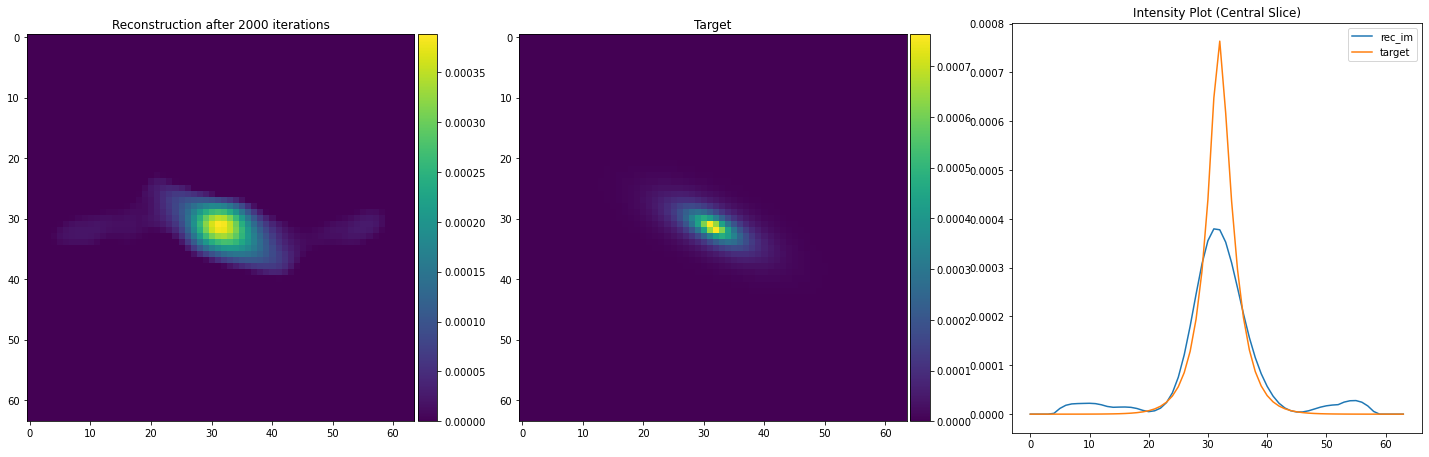

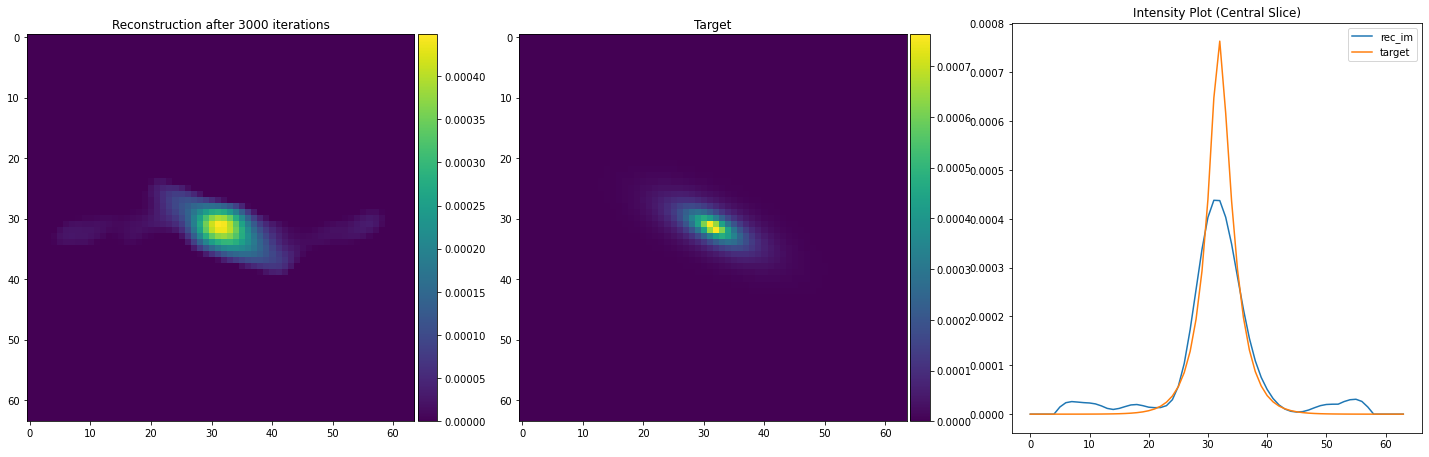

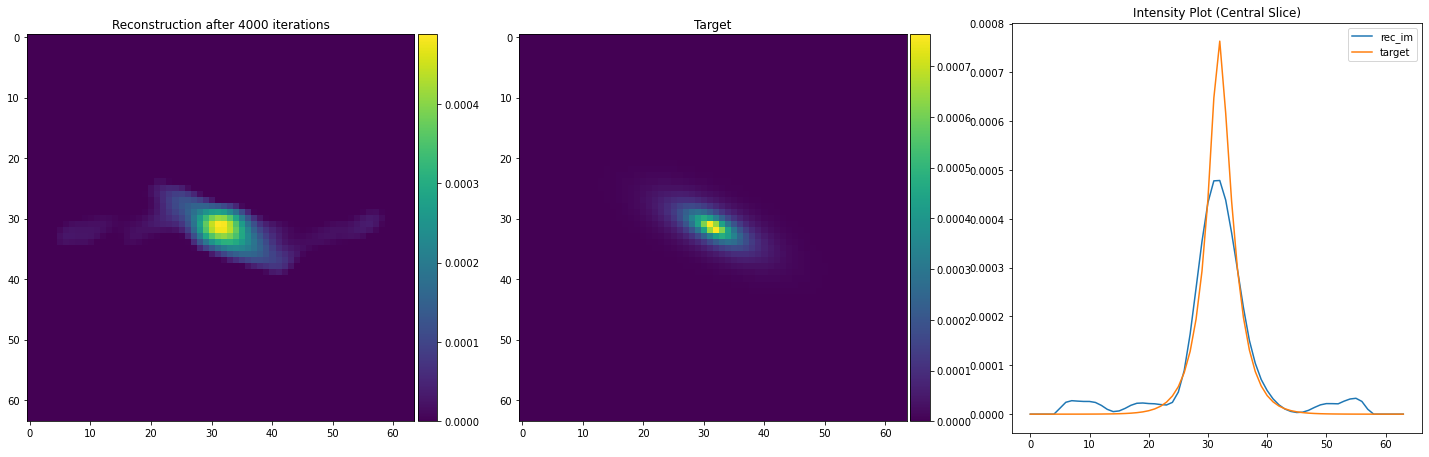

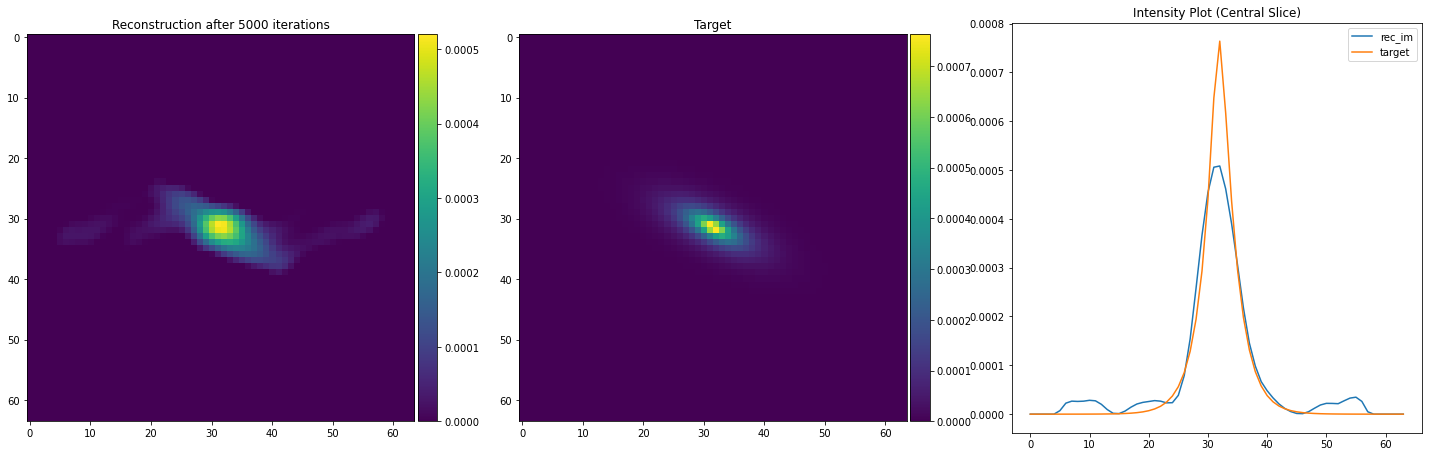

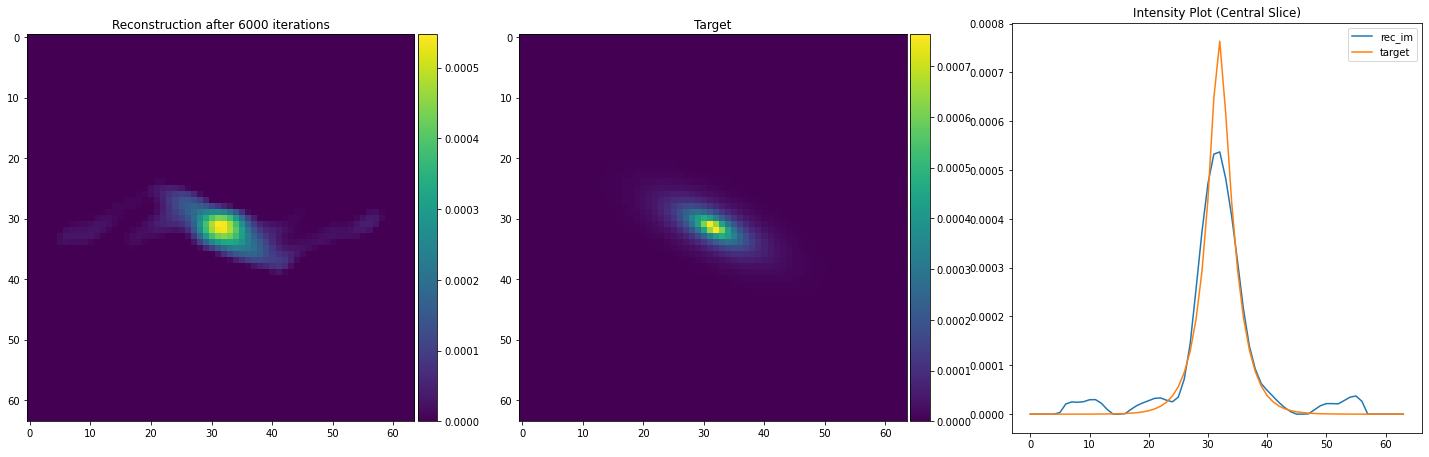

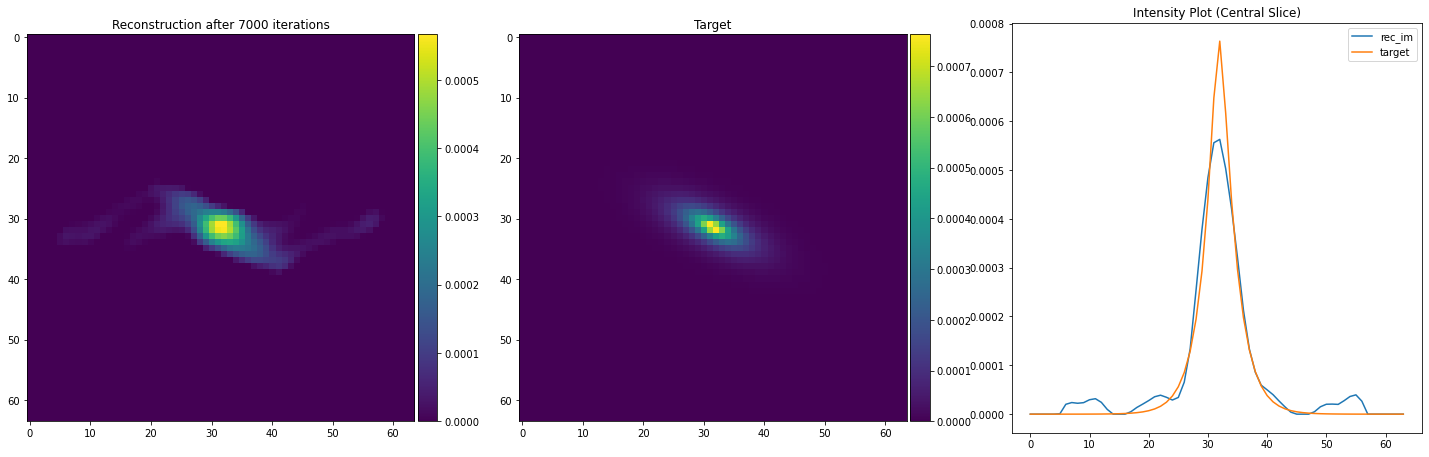

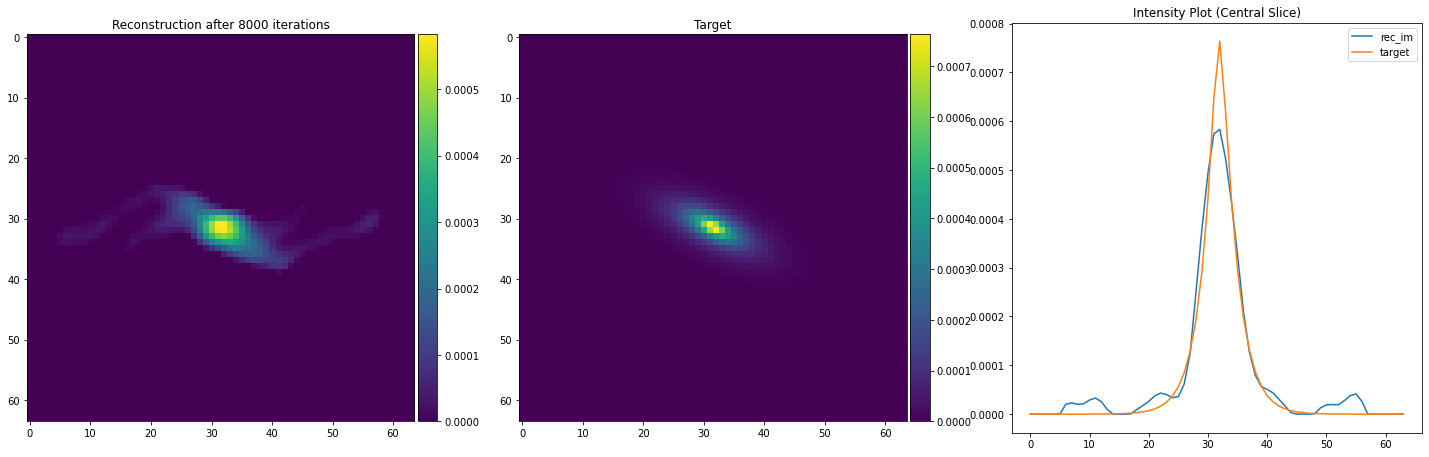

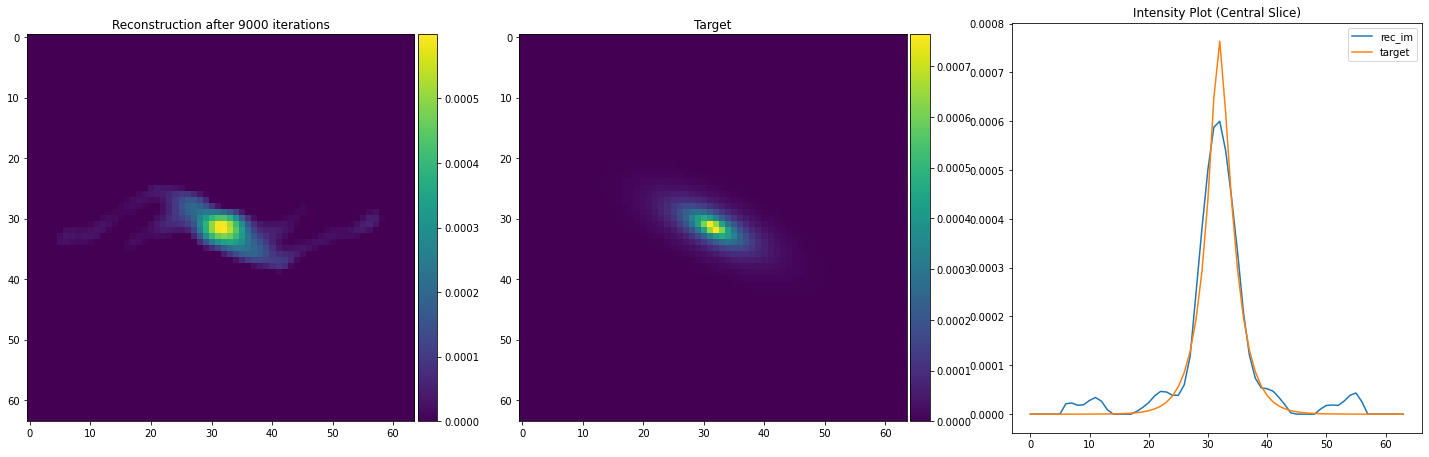

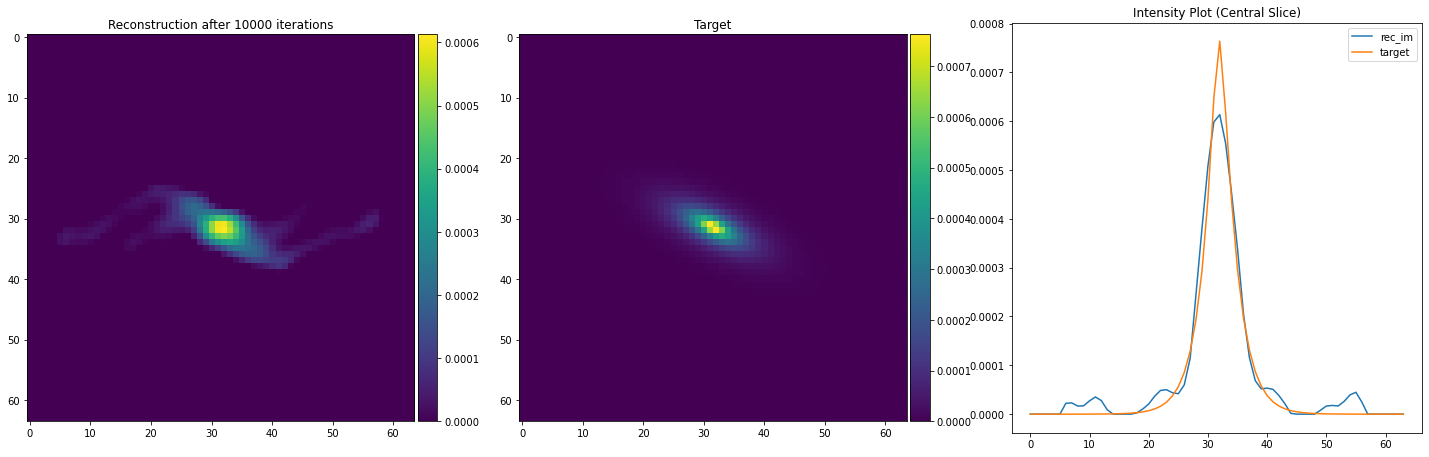

In [12]:
n_iter = 10000
disp_step = 1000

# ADMM parameters (initial)
x_0 = np.zeros(gal.shape)
z_0 = np.zeros(gal.shape)
mu_0 = 0.0                              
rho_0 = 50.0                         # Augmented lagrangian hyperparameter
rho_max = 200.0                      # max rho value
eta = 0.5                            # should be between - [0, 1)
gamma = 1.4                          # multiplicative rho factor -- Should be > 1

# Deconvolve the image
x_opt, cost, nmse_arr = runADMM(final_gal_tf, x_0, psf_tf, grad, z_0, mu_0, rho_0, 
                                rho_max, eta, gamma, disp_step, n_iter)

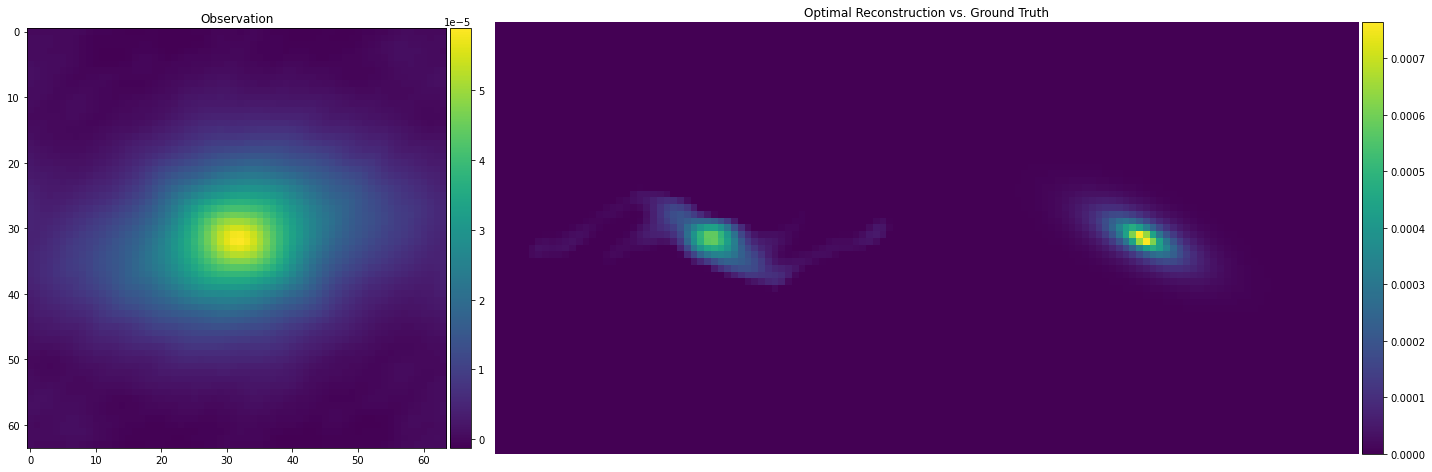

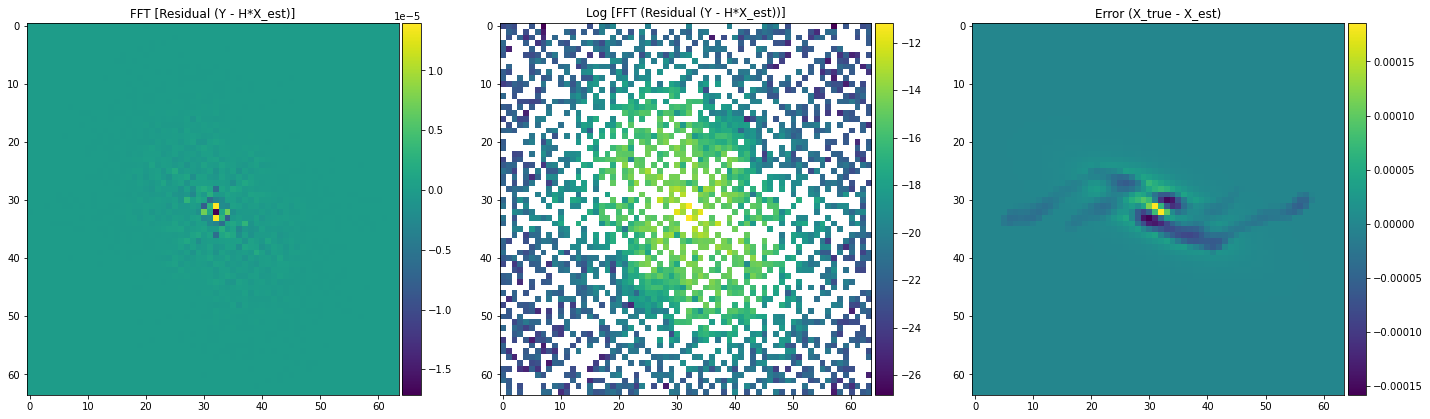

In [13]:
# Comparison
plot_utils.comparison_fft(x_opt, gal_tf, final_gal_tf, psf_tf, fftconvolve, fft)

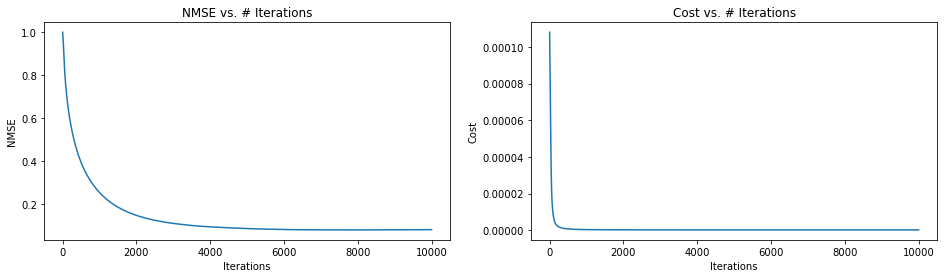


Minimum NMSE = 0.08175534009933472 (at [7793 7795 7796] iterations)
Minimum Cost = 2.0776761289198475e-07 (at [10000] iterations)


In [14]:
# Plot NMSE
plot_utils.nmse_cost(nmse_arr, cost, n_iter)